# VAE训练

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from datas import *
from modelDefine import VAE, vae_loss

X_train = get_data("./datas") # channel, height, width

In [2]:
#37249284674400
torch.manual_seed(37077366611700)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# create the dataloader
X_train = torch.from_numpy(X_train)
dataset = TensorDataset(X_train)

batchsize = 32
dataloader = DataLoader(dataset, batchsize, shuffle=True)

In [4]:
# create an instance of VAE model

channel, height, width = X_train.shape[1:]
latent_dim = 20
vae = VAE(channel, height, width, latent_dim).to(device)

vae

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mean): Linear(in_features=2048, out_features=20, bias=True)
  (fc_log_var): Linear(in_features=2048, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=2048, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(32, 8, 8))
    (2): ReLU()
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): Sigmoid()
  )
)

In [5]:
# train the vae 

optimizer = Adam(vae.parameters(), lr=.003)
num_epochs = 500

vae.train()
loss_list = []
epoch_list = []
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch[0].to(device)
        reconstruction, mean, log_var = vae(x)
        loss = vae_loss(reconstruction, x, mean, log_var)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    running_loss = total_loss / len(dataloader)
    loss_list.append(running_loss)
    epoch_list.append(epoch+1)
    if epoch % 10 == 9:
        print(f"Epoch [{epoch+1}/{num_epochs}],\tLoss: {running_loss:.4f}")

Epoch [10/500],	Loss: 54359.1961
Epoch [20/500],	Loss: 53470.0818
Epoch [30/500],	Loss: 53070.8752
Epoch [40/500],	Loss: 52824.3210
Epoch [50/500],	Loss: 52683.2459
Epoch [60/500],	Loss: 52556.3870
Epoch [70/500],	Loss: 52471.5609
Epoch [80/500],	Loss: 52410.0034
Epoch [90/500],	Loss: 52380.6458
Epoch [100/500],	Loss: 52264.3899
Epoch [110/500],	Loss: 52227.0775
Epoch [120/500],	Loss: 52206.8699
Epoch [130/500],	Loss: 52163.3720
Epoch [140/500],	Loss: 52066.7569
Epoch [150/500],	Loss: 52067.5868
Epoch [160/500],	Loss: 52040.6926
Epoch [170/500],	Loss: 52025.0917
Epoch [180/500],	Loss: 52015.2105
Epoch [190/500],	Loss: 51981.7971
Epoch [200/500],	Loss: 52000.9708
Epoch [210/500],	Loss: 51960.5780
Epoch [220/500],	Loss: 51942.4682
Epoch [230/500],	Loss: 51906.8093
Epoch [240/500],	Loss: 51911.1124
Epoch [250/500],	Loss: 51881.1448
Epoch [260/500],	Loss: 51874.2225
Epoch [270/500],	Loss: 51871.0224
Epoch [280/500],	Loss: 51852.0375
Epoch [290/500],	Loss: 51844.8355
Epoch [300/500],	Loss: 

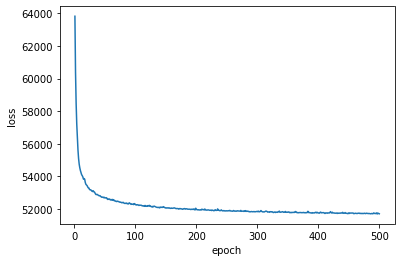

In [6]:
# plot the loss curve

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epoch_list, loss_list)

In [7]:
vae.to('cpu')
vae.eval()

reconstruction, _, __ = vae(X_train)
reconstruction.shape

torch.Size([1000, 3, 32, 32])

In [8]:
# denormalize the output tensor

def denormalize(output):
    denormalized = []
    for x in output:
        x = x.detach() * 255
        x = np.array(x).astype(np.uint8)
        x = np.transpose(x, (1,2,0))
        denormalized.append(x)
    return denormalized

In [9]:
# renormalize the reconstruction image

reconstruction_img = []
reconstruction_img = denormalize(reconstruction)
reconstruction_img = np.array(reconstruction_img)

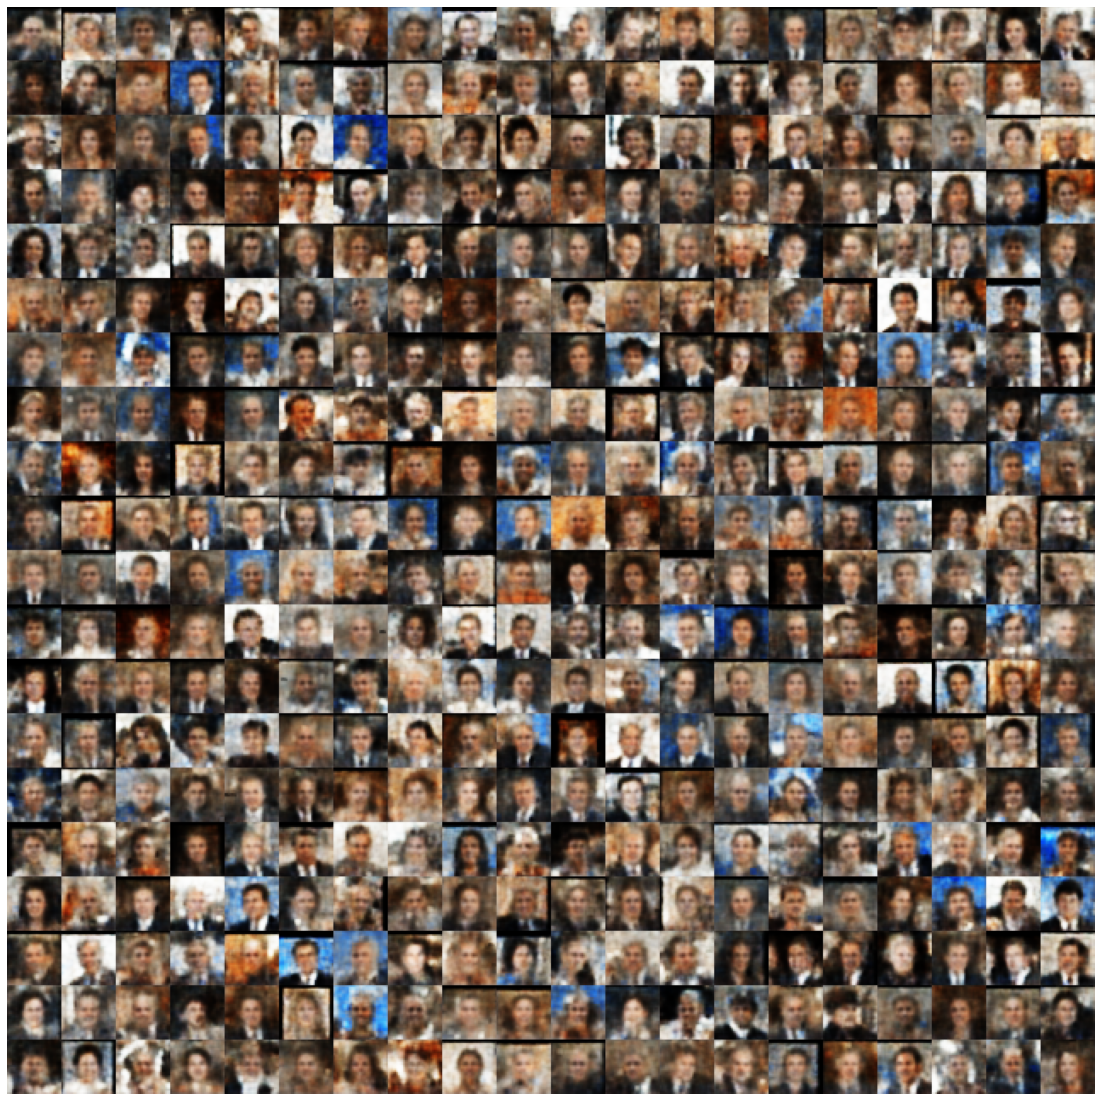

In [10]:
# create a big picture

reconstruction_img = reconstruction_img.reshape((-1,20,32,32,3))

img_lines = []
for imgs in reconstruction_img[:20]:
    img_line = np.concatenate(imgs, axis=1)
    img_lines.append(img_line)
big_img = np.concatenate(np.array(img_lines))
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(big_img)

# 线性插值

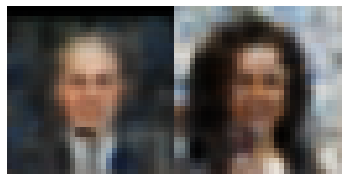

In [11]:
# choose two tensors from Z

vae.eval()

mean, log_var = vae.encode(X_train)
Z = vae.reparameterize(mean, log_var)

z1,z2 = Z[14],Z[80]
z1,z2 = z1.detach(), z2.detach()
output = vae.decode(torch.stack([z1,z2]))
output = denormalize(output)

plt.axis('off')
plt.imshow(np.concatenate(output, axis=1))

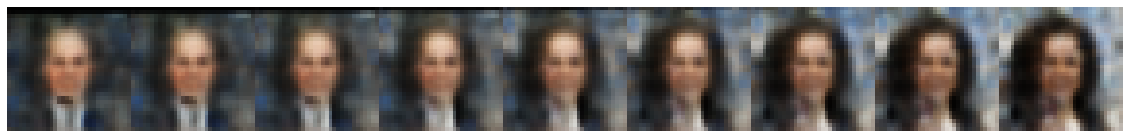

In [12]:
# use z1 and z2 to do interpolation

inter_list = []

for i in range(1,10):
    alpha = i/10
    inter_z = (1-alpha) * z1 + alpha * z2
    inter_list.append(inter_z)

inter_tensor = torch.stack(inter_list)
inter_output = vae.decoder(inter_tensor)
inter_output = denormalize(inter_output)

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(np.concatenate(inter_output,axis=1))

In [13]:
print(torch.initial_seed())

37077366611700


In [14]:
# save the model
torch.save(vae, './models/vae.pth')